## _PandaML_

- Perform detailed Exploratory Data Analysis on STT Data.

In [37]:
import os
import glob
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import trackml.dataset
import tensorflow as tf
import seaborn as sns

In [2]:
path = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

### _Input Pipeline_

In [19]:
# load event (hits) using trackml.dataset (update: pandaroot will now generate tubes.csv as cells.csv)
event_id = 1
prefix = path + str('event{!s}'.format(format(event_id, '010d')))
hits, tubes, particles, truth = trackml.dataset.load_event(prefix)

In [20]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,6.99749,15.150000,35.0,9,0,99
1,2,7.87217,15.655000,35.0,9,1,208
2,3,7.87217,16.665001,35.0,9,2,324
3,4,7.87217,17.674999,35.0,9,3,446
4,5,8.74686,18.180000,35.0,9,4,573


In [23]:
tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.104147,10223000.0,10.22300,9,0,99,0,5
1,2,0.477515,1246860.0,1.24686,9,1,208,0,5
2,3,0.028947,6736290.0,6.73629,9,2,324,0,5
3,4,0.414719,4375780.0,4.37578,9,3,446,0,5
4,5,0.152061,6719330.0,6.71933,9,4,573,0,5


In [28]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,-1.452330,-1.950250,-0.306385,1,1,13,0
1,2,0.0,0.0,0.0,-0.261170,-1.131130,-0.300518,1,1,13,0
2,3,0.0,0.0,0.0,0.969288,0.779675,0.190717,1,1,13,0
3,4,0.0,0.0,0.0,0.218074,0.802688,1.340770,1,1,13,0
4,5,0.0,0.0,0.0,0.763200,0.793767,1.781970,1,1,13,0


In [29]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,7.08407,15.108000,-5.88552,0.830402,1.71179,-0.672612,0.0,10
1,2,7.44967,15.860600,-6.18132,0.832640,1.71078,-0.672359,0.0,10
2,3,7.84790,16.676901,-6.50209,0.835152,1.70969,-0.671927,0.0,10
3,4,8.24646,17.491501,-6.82236,0.837543,1.70842,-0.672095,0.0,10
4,5,8.61632,18.244200,-7.11861,0.839886,1.70727,-0.672058,0.0,10


### _Exploratory Data Analysis_

In [30]:
# first drop skewed straws. later z-axis
# hits.query('skewed==0').head()

In [31]:
plt.style.use('ggplot')

In [32]:
# truth_s = truth[['tx','ty','tz','tpx','tpy','tpz']]
# _ = truth_s.hist(figsize = (8,8))

In [33]:
# particles_s = particles[['px','py','pz']]
# _ = particles_s.hist(figsize = (8,8))

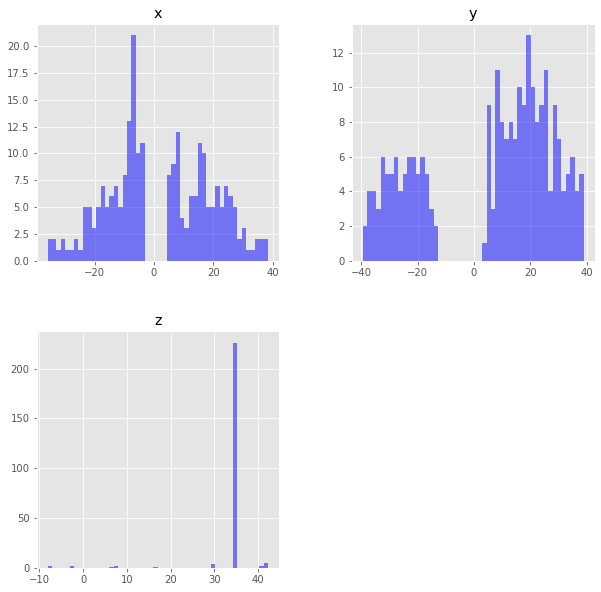

In [35]:
# Pandas: Histogram
hits_s = hits[['x', 'y', 'z']]
_ = hits_s.hist(color='b', alpha=0.5, bins=50, figsize=(10,10))

In [44]:
# Pandas: Box Plot
# color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}
# hits_s.plot.box(color=color, sym='r+', figsize=(10,10))

In [45]:
# Pandas: Scatter Plot
# hits_s.plot.scatter(x='x', y='y');

In [46]:
# Pandas: Histogram Stacked
# hits_s.plot.hist(stacked=True, bins=20, figsize=(10,10))

In [47]:
# Pandas: Scatter Matrix:
#_ = pd.scatter_matrix(hits_s, figsize=(12, 12), diagonal='hist')
#_ = pd.plotting.scatter_matrix(hits_s,figsize=(12, 12), diagonal='kde')

In [48]:
# Seaborn: Pair Plot
# _ = sns.pairplot(hits_s)

In [49]:
# Seaborn: Heatmap
# plt.figure(figsize=(10,10))
# _ = sns.heatmap(hits_s.corr(), annot=True,cmap ='RdYlGn')  # seaborn has very simple solution for heatmap

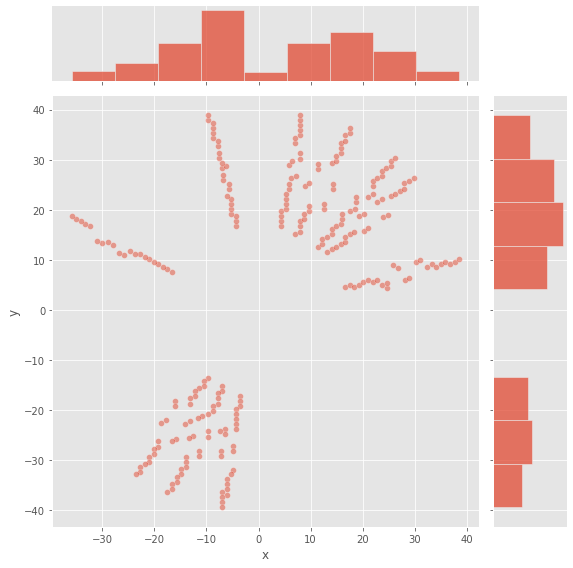

In [49]:
sns.jointplot(x="x", y="y", data=hits, alpha=0.5, height=8);

In [45]:
particles.iloc[4,0]

5

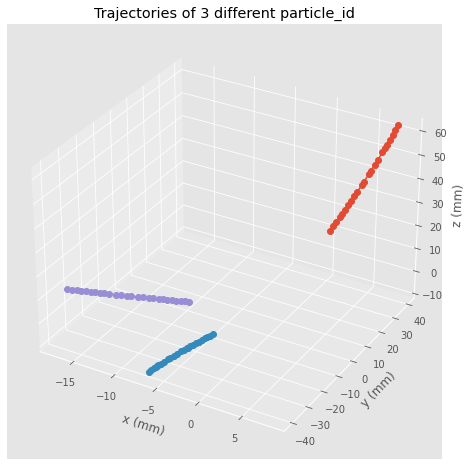

In [47]:
### Truth dataset
# For starters, let's see some trajectories from the truth dataset.

#get the information for some particles
truth_0 = truth[truth.particle_id == particles.iloc[3,0]]
truth_1 = truth[truth.particle_id == particles.iloc[1,0]]
truth_2 = truth[truth.particle_id == particles.iloc[7,0]]

#create figure instance
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

#plot each particle's path
ax.plot(
    xs=truth_0.tx,
    ys=truth_0.ty,
    zs=truth_0.tz, marker='o')

ax.plot(
    xs=truth_1.tx,
    ys=truth_1.ty,
    zs=truth_1.tz, marker='o')

ax.plot(
    xs=truth_2.tx,
    ys=truth_2.ty,
    zs=truth_2.tz, marker='o')

ax.set_title('Trajectories of 3 different particle_id')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
plt.show()

In [48]:
# Get every 100th particle
tracks = truth.particle_id.unique()[1::100]

plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
for track in tracks:
    t = truth[truth.particle_id == track]
    ax.plot3D(t.tz, t.tx, t.ty)
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
# These two added to widen the 3D space
ax.scatter(3000,3000,3000, s=0)
ax.scatter(-3000,-3000,-3000, s=0)
plt.show()

AttributeError: 'DataFrame' object has no attribute 'particle_id'

In [ ]:
# Number of unique particles
len(truth.particle_id.unique())

In [18]:
particle_ids = np.sort(particle_ids)
particle_ids

array([11, 12, 13, ..., 982103, 985242, 995151], dtype=object)

In [25]:
hits[hits.particle_id == 13]

,hit_id,x,y,z,tube_id,skewed,layer_id,sector_id,isochrone,depcharge,particle_id
26,115,6.1228,-15.655,35,57,0,0,3,0.468748,4.41747e+06,13
27,116,6.1228,-16.665,35,164,0,1,3,0.11942,2.27318e+07,13
28,117,6.1228,-17.675,35,277,0,2,3,0.209066,1.19902e+07,13
29,118,6.99749,-18.18,35,397,0,3,3,0.45377,6.23718e+06,13
30,119,6.99749,-19.19,35,522,0,4,3,0.090913,1.65801e+07,13
31,120,6.99749,-20.2,35,653,0,5,3,0.231898,1.64922e+07,13
32,121,7.87217,-20.705,35,791,0,6,3,0.418135,9.16185e+06,13
33,122,7.87217,-21.715,35,934,0,7,3,0.0595036,1.29907e+07,13
42,131,11.3709,-30.805,35,2861,0,16,3,0.293707,2.26915e+07,13
43,132,11.3709,-31.815,35,3076,0,17,3,0.0266306,2.59976e+07,13
